# Projet MLOps: Segmentation des clients Olist

## Notebook 2: Modèles

Dans le premier notebook nous avons eu à effectuer l'analyse exploratoire des données ainsi que le feature engineering afin de créer un jeu de données que nous pourrons utiliser pour faire notre segmentation.</br> Dans ce notebook nous allons donc procéder à la segmentation des clients</br>

En utilisant les résultats de cette segmentatiom, l'équipe marketing d'Olist pourra maximiser l'efficacité de ses campagnes et améliorer l'engagement et la satisfaction des clients.

<img src="https://media.licdn.com/dms/image/D5612AQEbR-vj1LqUFw/article-cover_image-shrink_600_2000/0/1693362637757?e=2147483647&v=beta&t=yD-EP9-YR-_gitRaxxiAGd5jzvvlnrjyzuSgVfXYDQY" alt="dataset_configuration" width="1200"/>

## Import des bibliothèques

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
import warnings
import mlflow
import pandas as pd
import numpy as np
import pendulum
import matplotlib.pyplot as plt
import seaborn as sns

from mlflow.tracking import MlflowClient
from loguru import logger
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from mlflow.models.signature import infer_signature
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import pickle

sys.path.append(str(Path.cwd().parent))
from settings.params import PARAMS
from src.load_dataset import load_data

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 25)
warnings.filterwarnings("ignore")

In [2]:
# Set logging format
log_fmt = (
    "<blue>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</blue> | "
    "<level>{level: <8}</level> | "
    "<green>{name}</green>:<magenta>{function}</magenta>:<yellow>{line}</yellow> | "
    "<cyan>Thread: {thread.name}</cyan> | "
    "<white>PID: {process}</white> - {message}"
)
logger.configure(handlers=[{'sink': sys.stderr, 'format': log_fmt}])

# Current date
CURRENT_DATE = pendulum.now(tz="UTC")

# Directories
PROJECT_DIR = Path.cwd().parent
OUTPUTS_DIR = Path(PROJECT_DIR, "output_files")
API_DIR = Path(PROJECT_DIR, "API")

logger.info(f"Project directory: {PROJECT_DIR}, Outputs directory: {OUTPUTS_DIR}, API directory: {API_DIR}")

2024-08-04 14:14:51.501 | INFO     | __main__:<module>:19 | Thread: MainThread | PID: 30399 - Project directory: /Users/massamba/Desktop/MLOps/projet_mlops, Outputs directory: /Users/massamba/Desktop/MLOps/projet_mlops/output_files, API directory: /Users/massamba/Desktop/MLOps/projet_mlops/API


## Entrainement et Tracking

In [3]:
df_rfm = load_data(f"{OUTPUTS_DIR}/segmentation_01_analyse_rfm_dataset.csv")

2024-08-04 14:14:51.522 | INFO     | src.load_dataset:load_data:17 | Thread: MainThread | PID: 30399 - Dataset path to load /Users/massamba/Desktop/MLOps/projet_mlops/output_files/segmentation_01_analyse_rfm_dataset.csv
2024-08-04 14:14:51.619 | INFO     | src.load_dataset:load_data:27 | Thread: MainThread | PID: 30399 - Data shape: (96967, 9)


                        customer_id  total_spent  frequency  avg_installments  \
0  00012a2ce6f8dcda20d059ce98491703        89.80          1               8.0   
1  000161a058600d5901f007fab4c27140        54.90          1               5.0   
2  0001fd6190edaaf884bcaf3d49edf079       179.99          1              10.0   
3  0002414f95344307404f0ace7a26f1d5       149.90          1               1.0   
4  000379cdec625522490c315e70c7a9fb        93.00          1               1.0   
5  0004164d20a9e969af783496f3408652        59.99          1               1.0   
6  000419c5494106c306a97b5635748086        34.30          1               4.0   
7  00046a560d407e99b969756e0b10f282       120.90          1               5.0   
8  00050bf6e01e69d5c0fd612f1bcfb69c        69.99          1               8.0   
9  000598caf2ef4117407665ac33275130      1107.00          1              10.0   

   total_items  payment_price_ratio  recency  avg_fractional_payment_ratio  \
0          1.0             1.2

### Détermination du nombre de clusters optimal pour chaque modèle

In [4]:
X = df_rfm.drop("customer_id", axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = PCA(n_components=0.95)
X_transformed = model.fit_transform(X_scaled)

#### KMeans

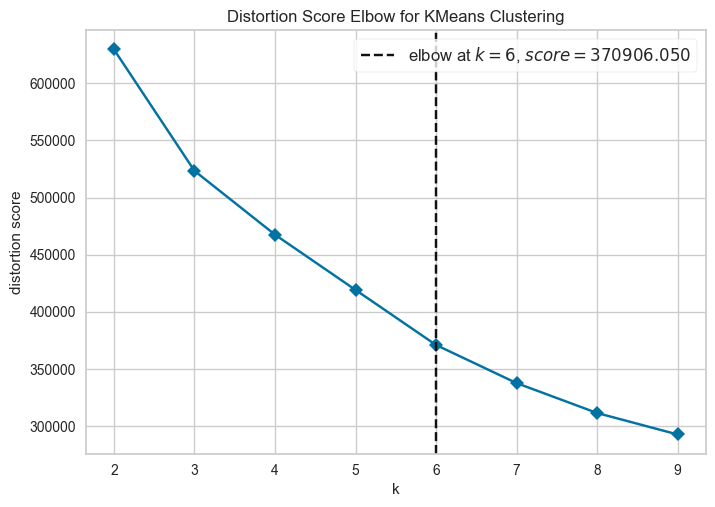

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
visualizer = KElbowVisualizer(KMeans(random_state=PARAMS["SEED"]), k=(2,10), timings=False)
visualizer.fit(X_transformed)
visualizer.show()

In [6]:
n_clusters_kmeans = visualizer.elbow_value_

#### GaussianMixture

In [7]:
n_components = range(1, 11)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = PARAMS["SEED"])
        gmm.fit(X_transformed)
        score.append((cov,n_comp,gmm.bic(X_transformed)))
score_1 = pd.DataFrame(score)
score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
score_2 = score_1[score_1.BIC_Score == score_1.BIC_Score.min()]

score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
37,full,8,-854773.57132


In [8]:
n_components_gauss = score_2.head(n=2).N_Components.values[0]

#### DBSCAN

0.4567759568703497


<Figure size 500x500 with 0 Axes>

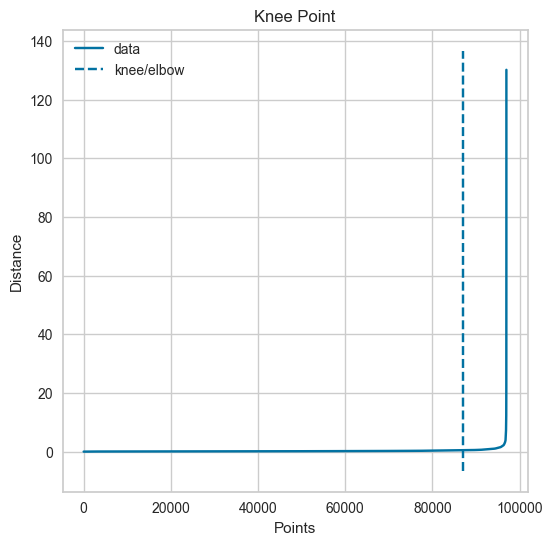

In [9]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_transformed)
distances, indices = neighbors.kneighbors(X_transformed)
distances = np.sort(distances[:,10], axis=0)


i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [10]:
eps_dbscan = distances[knee.knee]

### MLFlow

In [11]:
ESTIMATOR_PARAMS = {
    "DBSCAN": {
        "estimator": DBSCAN,
        "params": {"eps": eps_dbscan, "min_samples": 2}
    },
    "KMeans": {
        "estimator": KMeans,
        "params": {"n_clusters": n_clusters_kmeans, "random_state": PARAMS["SEED"]}
    },
    "GaussianMixture": {
        "estimator": GaussianMixture,
        "params": {"n_components": n_components_gauss, "random_state": PARAMS["SEED"]}
    }
}

In [12]:
experiment_name = PARAMS["EXPERIMENT_NAME"]
mlflow.set_experiment(experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

2024/08/04 14:18:06 INFO mlflow.tracking.fluent: Experiment with name 'Olist_RFM_Segmentation' does not exist. Creating a new experiment.


In [13]:
for model_name, model_config in ESTIMATOR_PARAMS.items():
    estimator = model_config["estimator"]
    params = model_config["params"]

    with mlflow.start_run(run_name=f"{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}-RFM-Segmentation-{model_name}",
                            experiment_id=experiment_id,
                            tags={"version": "v1", "priority": "P1"},
                            description="RFM segmentation modeling",
                            ) as mlf_run:
        logger.info(f"run_id: {mlf_run.info.run_id}")
        logger.info(f"version tag value: {mlf_run.data.tags.get('version')}")

        mlflow.log_params(params)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)),
            ('estimator', estimator(**params))
        ])

        pipeline.fit(X)

        # Predict cluster labels
        if hasattr(pipeline.named_steps['estimator'], 'labels_'):
            labels = pipeline.named_steps['estimator'].labels_
        else:
            labels = pipeline.predict(X)

        # Calculate and log metrics
        if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            mlflow.log_metric("silhouette_score", silhouette)
            mlflow.log_metric("calinski_harabasz_score", calinski_harabasz)
            mlflow.log_metric("davies_bouldin_score", davies_bouldin)

        logger.info(f"Estimator: {pipeline[-1].__class__.__name__}")
        logger.info(f"Silhouette Score: {silhouette} --- Calinski Score: {calinski_harabasz} --- Davies Score: {davies_bouldin}")

        # Log the model
        signature = infer_signature(X, labels)

        mlflow.sklearn.log_model(pipeline, artifact_path=model_name, signature=signature, input_example=X[:5], registered_model_name=f"segmentation-olist-{model_name}")

        logger.info(f"Entrainement de {model_name} terminé et journalisé sur MLlow")

2024-08-04 14:18:06.338 | INFO     | __main__:<module>:10 | Thread: MainThread | PID: 30399 - run_id: 5006c14a12a14e0783744143ae436ba8
2024-08-04 14:18:06.340 | INFO     | __main__:<module>:11 | Thread: MainThread | PID: 30399 - version tag value: v1
2024-08-04 14:19:55.377 | INFO     | __main__:<module>:39 | Thread: MainThread | PID: 30399 - Estimator: DBSCAN
2024-08-04 14:19:55.378 | INFO     | __main__:<module>:40 | Thread: MainThread | PID: 30399 - Silhouette Score: -0.8480206143797059 --- Calinski Score: 40.835428739028245 --- Davies Score: 3.0073065798530485
2024/08/04 14:19:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'segmentation-olist-DBSCAN'.
Created version '1' of model 'segmentation-olist-DBSCAN'.
2024-08-04 14:19:57.982 | INFO     | __main__:<module>:47 | Thread: MainThread | PID: 30399 - Entrainement de DBSCAN terminé et journalisé sur MLlow
2024-08-04 14:19:58.003 | INFO     | __main__:

En comparant les résultats obtenus, nous pouvons voir que le modèle KMeans présente les meilleurs performances avec le plus haut silhouette_socre et calinski_harabasz_score ainsi que le plus faible davies_bouldin_score</br>
Nous allons donc  sauvegarder et utiliser ce modèle dans la suite

In [26]:
model_name = "segmentation-olist-KMeans"
client = MlflowClient()
latest_version = client.get_latest_versions(model_name, stages=["None"])[0].version
model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{latest_version}")

In [27]:
with open(f'{OUTPUTS_DIR}/olist-kmeans-current.pkl', 'wb') as file:
    pickle.dump(model, file)

with open(f'{API_DIR}/models/olist-kmeans-current.pkl', 'wb') as file:
    pickle.dump(model, file)

### Interprétation des segments

In [28]:
with open(f'{OUTPUTS_DIR}/olist-kmeans-current.pkl', 'rb') as file:
    model = pickle.load(file)

In [29]:
model

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('estimator', KMeans(n_clusters=6, random_state=42))])

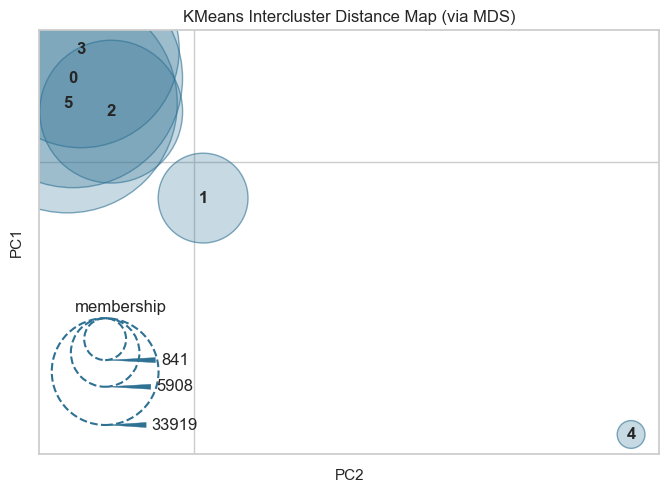

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [30]:
visualizer = InterclusterDistance(KMeans(n_clusters=n_clusters_kmeans, random_state=PARAMS["SEED"]))
visualizer.fit(X)
visualizer.show()

In [31]:
df_seg_kmeans = df_rfm.copy()
df_seg_kmeans['segments'] = model.predict(X)
df_seg_kmeans.head()

,customer_id,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,segments
0,00012a2ce6f8dcda20d059ce98491703,89.80,1,8.0,1.0,1.277728,292,0.069723,24.94,5
1,000161a058600d5901f007fab4c27140,54.90,1,5.0,1.0,1.227869,413,0.074173,12.51,5
2,0001fd6190edaaf884bcaf3d49edf079,179.99,1,10.0,1.0,1.085727,551,0.051172,15.43,5
3,0002414f95344307404f0ace7a26f1d5,149.90,1,1.0,1.0,1.196464,382,0.005576,29.45,1
4,000379cdec625522490c315e70c7a9fb,93.00,1,1.0,1.0,1.150645,153,0.009345,14.01,3


In [32]:
df_seg_kmeans.to_csv(f"{API_DIR}/data/segmentation_kmeans_result.csv", index=False)

In [33]:
df_analysis = df_seg_kmeans.groupby('segments').mean()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value
segments,,,,,,,,
0,287.032660,3.945106,3.410991,8.947409,4.732345,242.644914,0.005662,75.293693
1,108.817151,1.120197,1.837478,1.200127,1.388858,391.920170,0.018423,20.166559
2,803.214139,1.285966,6.861163,1.464034,1.263705,233.453001,0.010191,62.734325
3,105.161722,1.105944,1.741912,1.183374,1.397658,130.598023,0.017831,20.660649
4,2140.858511,16.297872,3.287234,67.063830,13.091529,257.893617,0.001933,429.856170
5,101.055637,1.045085,6.489864,1.088808,1.387808,260.746806,0.064440,19.427077


In [36]:
df_analysis['#observations'] = df_seg_kmeans[['segments','frequency']].groupby(['segments']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,#observations,Percentage
segments,,,,,,,,,,
0,287.032660,3.945106,3.410991,8.947409,4.732345,242.644914,0.005662,75.293693,2605,0.026865
1,108.817151,1.120197,1.837478,1.200127,1.388858,391.920170,0.018423,20.166559,29876,0.308105
2,803.214139,1.285966,6.861163,1.464034,1.263705,233.453001,0.010191,62.734325,4532,0.046738
3,105.161722,1.105944,1.741912,1.183374,1.397658,130.598023,0.017831,20.660649,42296,0.436190
4,2140.858511,16.297872,3.287234,67.063830,13.091529,257.893617,0.001933,429.856170,47,0.000485
5,101.055637,1.045085,6.489864,1.088808,1.387808,260.746806,0.064440,19.427077,17611,0.181618


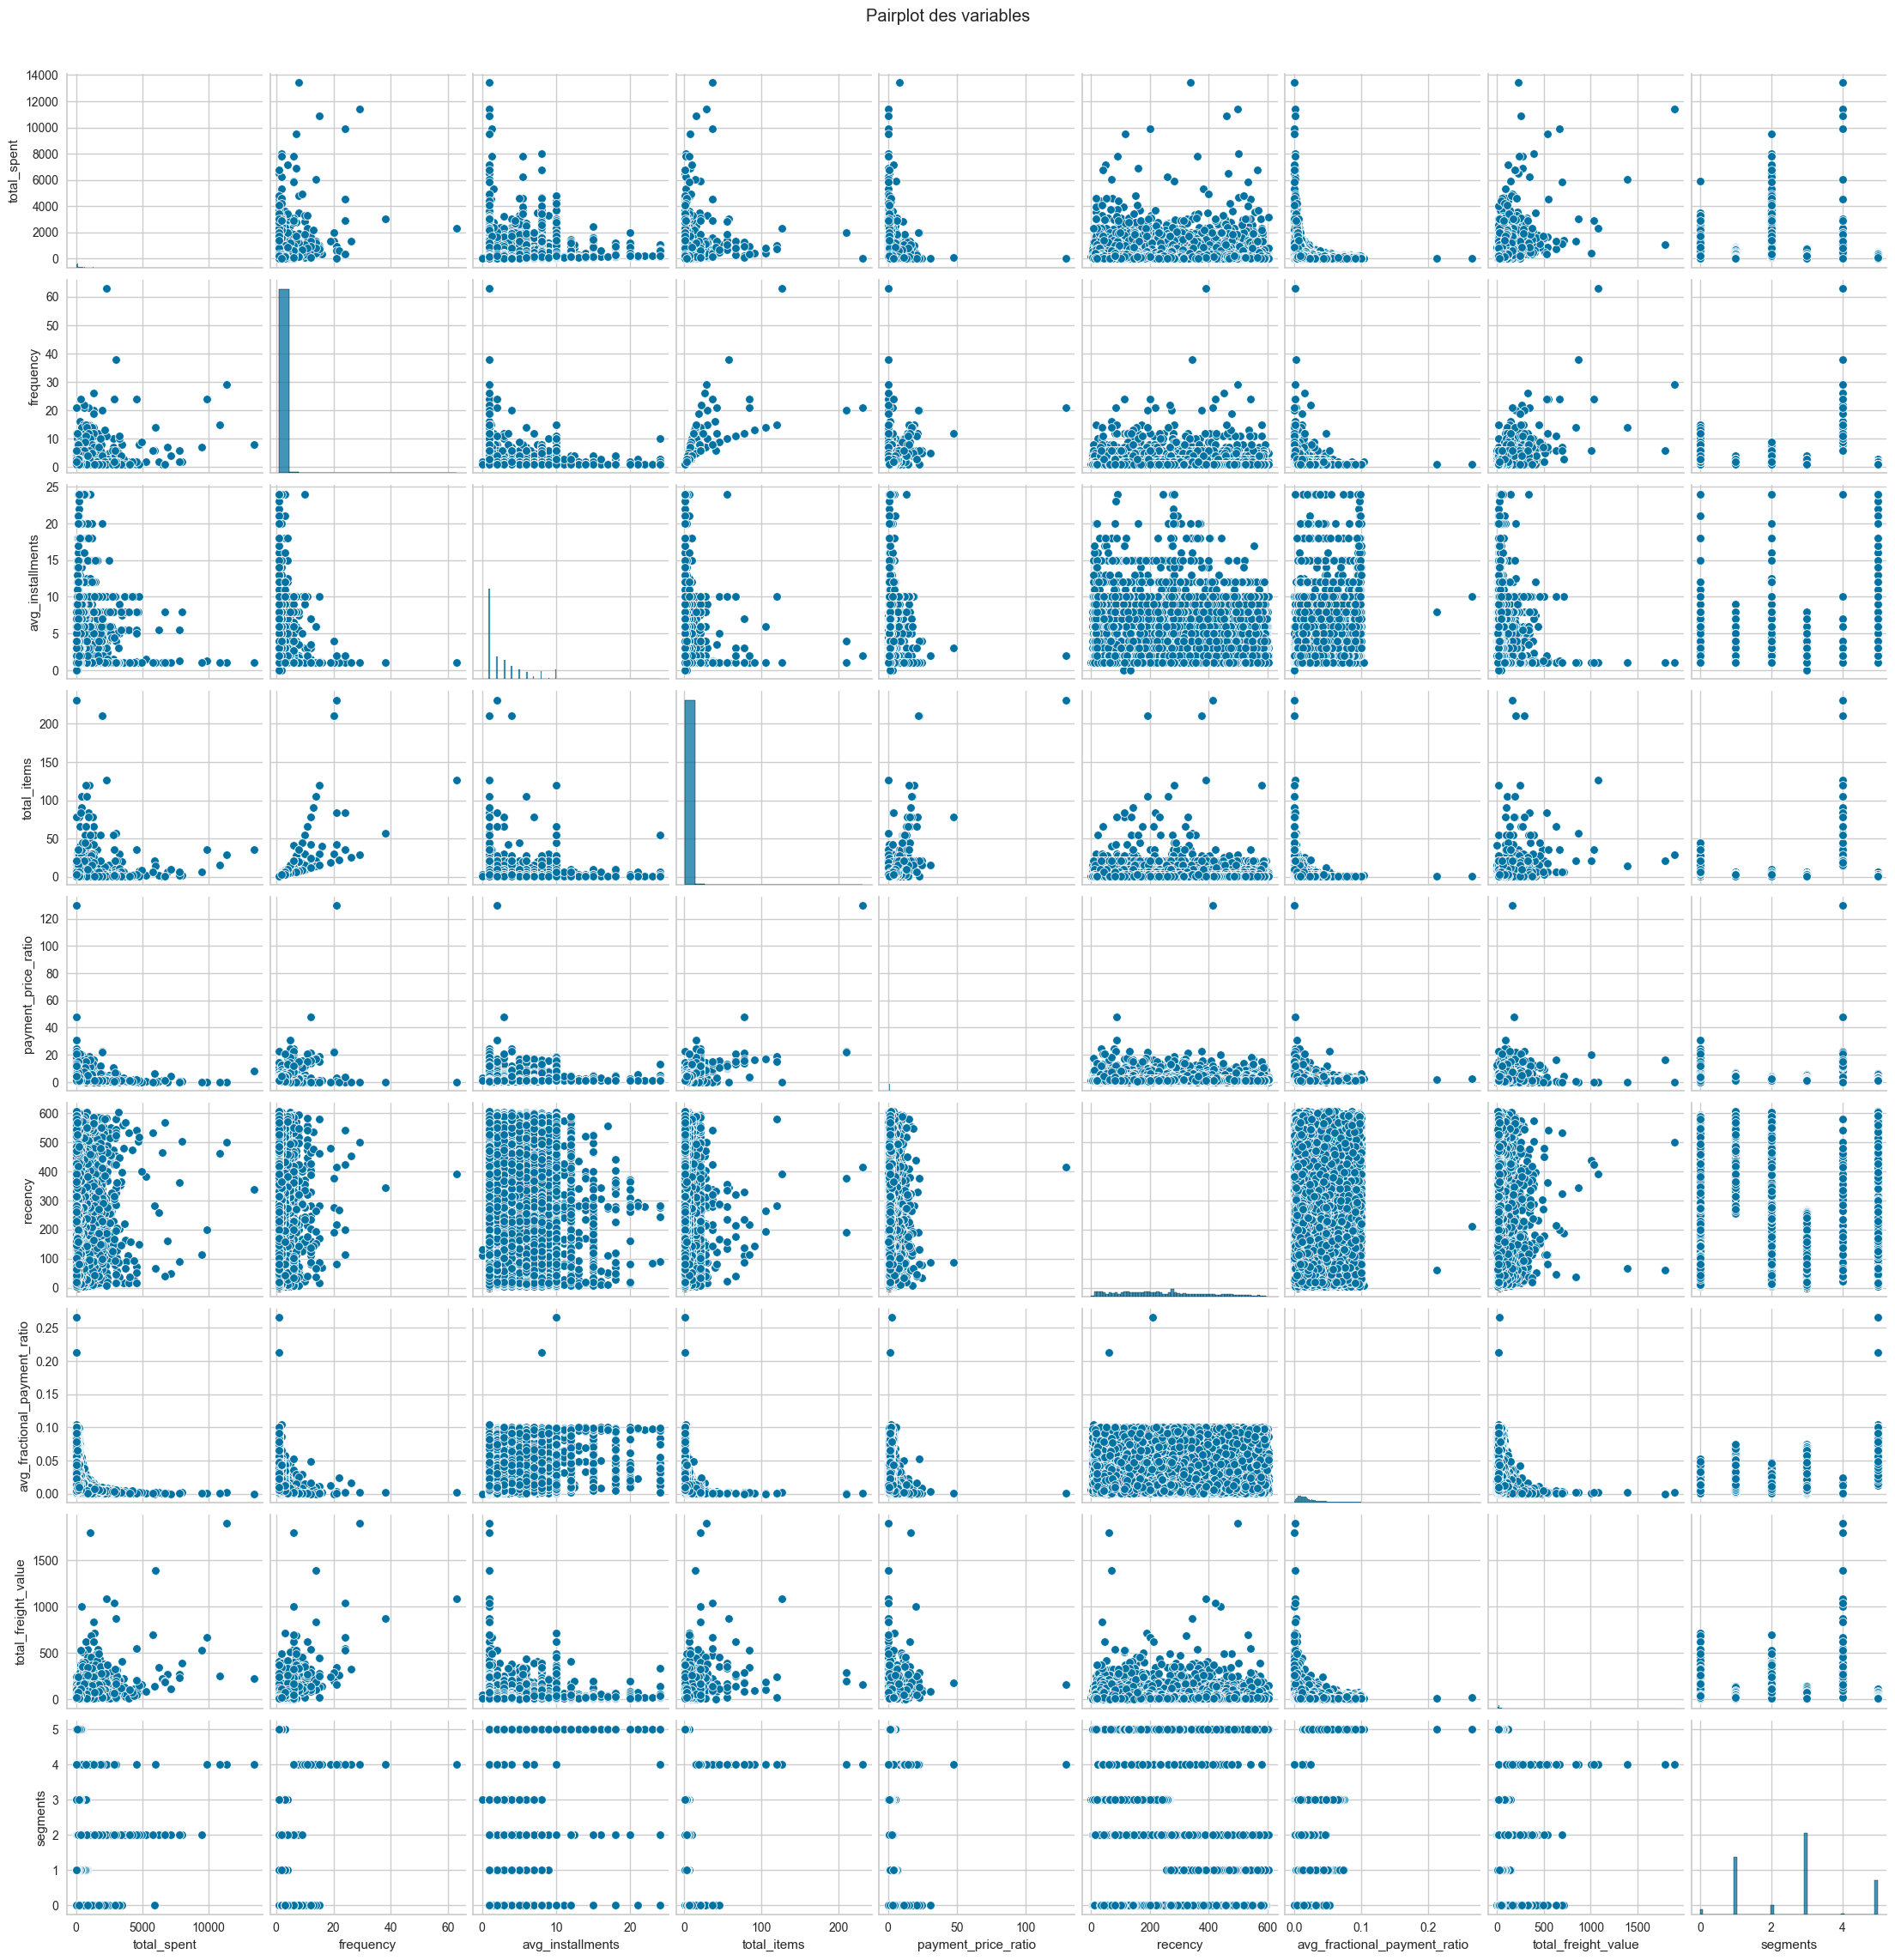

In [39]:
sns.pairplot(df_seg_kmeans[df_seg_kmeans.columns])
plt.suptitle('Pairplot des variables', y=1.02)
plt.show()

In [40]:
df_analysis

,total_spent,frequency,avg_installments,total_items,payment_price_ratio,recency,avg_fractional_payment_ratio,total_freight_value,#observations,Percentage
segments,,,,,,,,,,
0,287.032660,3.945106,3.410991,8.947409,4.732345,242.644914,0.005662,75.293693,2605,0.026865
1,108.817151,1.120197,1.837478,1.200127,1.388858,391.920170,0.018423,20.166559,29876,0.308105
2,803.214139,1.285966,6.861163,1.464034,1.263705,233.453001,0.010191,62.734325,4532,0.046738
3,105.161722,1.105944,1.741912,1.183374,1.397658,130.598023,0.017831,20.660649,42296,0.436190
4,2140.858511,16.297872,3.287234,67.063830,13.091529,257.893617,0.001933,429.856170,47,0.000485
5,101.055637,1.045085,6.489864,1.088808,1.387808,260.746806,0.064440,19.427077,17611,0.181618


## Interprétation des segmnts et recommandations marking

**Segment 0 : Clients à haute valeur avec achats fréquents et récents**
- **Description** : Ces clients ont la dépense totale la plus élevée (287.03), la fréquence d'achat la plus élevée (3.94), et des achats très récents (242.64 jours). Ils achètent de nombreux articles (8.97 en moyenne) et ont une valeur de fret élevée (75.29).
- **Actions Marketing** :
  - Programme VIP : Créer un programme exclusif avec des avantages premium pour récompenser et retenir ces clients de grande valeur.
  - Service client personnalisé : Offrir un service dédié pour répondre rapidement à leurs besoins et maintenir leur satisfaction.
  - Accès en avant-première : Proposer un accès prioritaire aux nouveaux produits ou ventes pour stimuler leur engagement continu.

**Segment 1 : Clients occasionnels à valeur moyenne**
- **Description** : Ces clients ont une dépense totale modérée (108.82), une fréquence d'achat plus basse (1.12), et des achats moins récents (391.92 jours). Ils achètent moins d'articles (1.20) mais ont un ratio de paiement fractionné plus élevé (0.018).
- **Actions Marketing** :
  - Campagnes de réactivation : Envoyer des offres personnalisées basées sur leurs achats passés pour les inciter à revenir.
  - Options de paiement flexibles : Mettre en avant les options de paiement échelonné pour encourager des achats plus importants.
  - Contenu engageant : Partager du contenu pertinent pour maintenir la connexion avec la marque entre les achats.

**Segment 2 : Clients à valeur élevée avec achats importants mais peu fréquents**
- **Description** : Ces clients ont une dépense totale élevée (803.21) malgré une fréquence d'achat modérée (1.29). Ils effectuent des achats importants (6.86 articles en moyenne) et ont une valeur de fret élevée (62.73).
- **Actions Marketing** :
  - Programmes de fidélité axés sur la valeur : Récompenser la valeur totale des achats plutôt que la fréquence.
  - Ventes croisées et montées en gamme : Suggérer des produits complémentaires ou haut de gamme lors de leurs visites.
  - Événements exclusifs : Organiser des événements spéciaux pour ces clients à forte valeur pour renforcer leur relation avec la marque.

**Segment 3 : Nouveaux clients ou clients à faible engagement**
- **Description** : Ces clients ont la dépense totale la plus faible (105.16), une basse fréquence d'achat (1.11), et des achats relativement récents (130.60 jours). Ils achètent peu d'articles (1.18) et ont une faible valeur de fret (20.66).
- **Actions Marketing** :
  - Programme d'onboarding : Mettre en place un parcours d'accueil pour les nouveaux clients afin de les familiariser avec l'offre.
  - Offres de découverte : Proposer des offres spéciales sur une gamme de produits pour encourager l'exploration de l'assortiment.
  - Enquêtes de satisfaction : Recueillir des feedbacks pour comprendre leurs besoins et améliorer leur expérience.

**Segment 4 : Clients à très haute valeur avec achats fréquents et volumineux**
- **Description** : Ces clients ont la dépense totale la plus élevée (2140.86), la fréquence d'achat la plus élevée (16.30), et achètent le plus grand nombre d'articles (67.06). Ils ont aussi la valeur de fret la plus élevée (429.86).
- **Actions Marketing** :
  - Service ultra-premium : Offrir un service de conciergerie dédié pour répondre à tous leurs besoins.
  - Co-création de produits : Les impliquer dans le développement de nouveaux produits ou services.
  - Avantages exclusifs : Proposer des avantages uniques comme la livraison gratuite à vie ou des remises permanentes pour maintenir leur fidélité.

**Segment 5 : Clients à faible valeur avec achats peu fréquents mais récents**
- **Description** : Ces clients ont la deuxième dépense totale la plus faible (101.06), une fréquence d'achat basse (1.05), mais des achats relativement récents (260.75 jours). Ils ont le ratio de paiement fractionné le plus élevé (0.064).
- **Actions Marketing** :
  - Offres d'encouragement : Proposer des remises sur le prochain achat pour augmenter la fréquence.
  - Éducation sur les produits : Fournir du contenu informatif pour augmenter la valeur perçue et justifier des achats plus importants.
  - Options de paiement flexibles : Mettre en avant les facilités de paiement pour réduire les barrières à l'achat.